# AB Testing Course - PA Bond

# 0.1 Imports

In [50]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats import api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp,shapiro,ttest_ind,mannwhitneyu,f_oneway,chi2_contingency
import seaborn as sns
from matplotlib            import pyplot as plt

# 1.0 Load Data

In [33]:
df_raw = pd.read_csv('../data/ab_testing.csv')

In [34]:
df_raw.shape

(45883, 8)

In [40]:
df_raw.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


# 2.0 Design de Experimentos

## 2.1 Formação das Hipóteses

O entregável do seu trabalho é o seguinte:
1. Qual a melhor forma de pagamento: Preenchimento Manual ou Automático do formulário de dados do cartão de crédito?

H0: O preenchimento manual  é melhor que o automático, é o sistema que vêm sendo usado e não há dados o suficiente ou uma diferença significativa que prove o contrário <br>
H1: O preenchimento automático é melhor forma de pagamento que o manual

Para descobrir isso faremos:
- Fazer um EDA, ver se falta alguma coisa e como estao as distribuições
- Conferir se não há clientes que estão em dois grupos
- Conferir os tamanhos dos grupos, se são equilibrados em relação a country, gender e device
- Para medir o sucesso da forma de pagamento, utilizeramos a quantidade de clientes que comprou, independente do quanto gastou ou do número de compras
- Depois podemos testar usando o valor total do cliente, sendo a multiplicação entre o número de compras e o valor gasto

A partir disso respondemos a pergunta de negócio, mas além disso, podemos levar:
- Essa hipótese é verdadeira se dividirmos por device?
- Essa hipotese é verdadeita se dividirmos por country?

# 3.0 EDA

## 3.1 Dimensões

In [36]:
print(f'Number of rows: {df_raw.shape[0]}')
print(f'Number of coljmns: {df_raw.shape[1]}')

Number of rows: 45883
Number of coljmns: 8


## 3.2 Dados Faltantes

In [37]:
df_raw.isna().sum()
#Sem NA

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

# 3.3 Tipos de dados

In [41]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.dtypes

uid                   int64
country              object
gender               object
spent                 int64
purchases             int64
date         datetime64[ns]
group                object
device               object
dtype: object

## 3.4 Conferir flags

In [42]:
contagem_clientes = df_raw.loc[:,'uid'].count()
clientes_distintos = df_raw.loc[:,'uid'].nunique()
if contagem_clientes == clientes_distintos:
  print(f'Não há clientes repetidos')
else:
  print(f'Há clientes que se repetem')

Não há clientes repetidos


In [43]:
df_raw.loc[:,['uid', 'group']].groupby(['group']).count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


In [44]:
df_raw.loc[:,['uid', 'group', 'device']].groupby(['group', 'device']).count().reset_index()

,group,device,uid
0,GRP A,A,11487
1,GRP A,I,11522
2,GRP B,A,11495
3,GRP B,I,11379


## 3.5 Estatística Descritiva

### 3.5 Variáveis numéricas

In [78]:
#Separando os tipos de tipos das colunas entre numéricas e categóricas
num_atrr = df_raw.select_dtypes(include=['int64','float64'])
cat_atrr = df_raw.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

df_A = df_raw.loc[df_raw['group'] == 'GRP A',:]
df_B = df_raw.loc[df_raw['group'] == 'GRP B',:]

In [79]:
# Ter uma noção geral das métricas do negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_atrr.apply(np.mean)).T
ct2 = pd.DataFrame(num_atrr.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atrr.apply(np.std)).T
d2 = pd.DataFrame(num_atrr.apply(np.min)).T
d3 = pd.DataFrame(num_atrr.apply(np.max)).T
d4 = pd.DataFrame(num_atrr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atrr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atrr.apply(lambda x: x.kurtosis())).T

#Concaterando as métricas
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,uid,11115722.0,99999383.0,88883661.0,5.544232e+07,55312026.0,2.558651e+07,0.007913,-1.190403
1,spent,99.0,12170.0,12071.0,1.883453e+03,1596.0,1.363907e+03,1.365817,2.627362
2,purchases,1.0,30.0,29.0,4.544385e+00,4.0,3.102420e+00,1.348301,2.562334


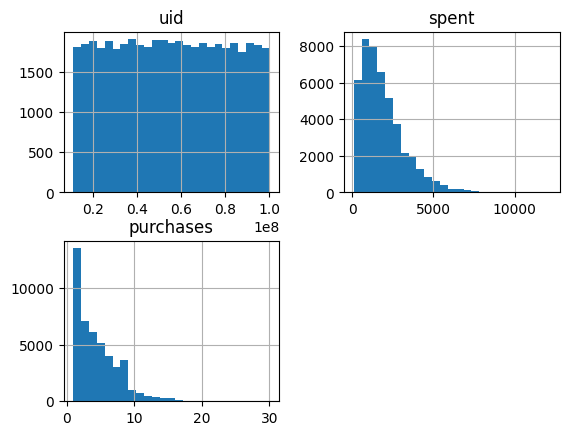

In [80]:
num_atrr.hist(bins = 25);

Sem anormalidades nas distribuições de compras e valor gasto

## 3.6 Variáveis categóricas

### 3.6.1 Distribuição de country por grupo

In [81]:
country_A = df_A['country'].value_counts(normalize=True).reset_index()
country_A.columns = ['country','GRUPO A (%)']

country_B = df_B['country'].value_counts(normalize=True).reset_index()
country_B.columns = ['country','GRUPO B (%)']

country_total = pd.merge(country_A,country_B,on='country',how='left')
country_total['dif'] = country_total['GRUPO A (%)'] - country_total['GRUPO B (%)']
country_total['dif'] = country_total['dif']*100
country_total['GRUPO B (%)'] = country_total['GRUPO B (%)']*100
country_total['GRUPO A (%)'] = country_total['GRUPO A (%)']*100
country_total

,country,GRUPO A (%),GRUPO B (%),dif
0,USA,30.105611,30.912827,-0.807216
1,BRA,19.635795,19.633645,0.002150
2,MEX,12.542918,11.550232,0.992686
3,DEU,8.214177,7.895427,0.318750
4,TUR,7.801295,7.615633,0.185662
5,FRA,6.227998,6.159832,0.068166
6,GBR,6.023730,6.221037,-0.197307
7,ESP,4.215742,4.214392,0.001350
8,CAN,3.033596,3.562997,-0.529402
9,AUS,2.199139,2.233977,-0.034838


### 3.6.2 Distribuição de gender por grupo

In [82]:
gender_A = df_A['gender'].value_counts(normalize=True).reset_index()
gender_A.columns = ['gender','GRUPO A (%)']

gender_B = df_B['gender'].value_counts(normalize=True).reset_index()
gender_B.columns = ['gender','GRUPO B (%)']

gender_total = pd.merge(gender_A,gender_B,on='gender',how='left')
gender_total['dif'] = gender_total['GRUPO A (%)'] - gender_total['GRUPO B (%)']
gender_total['dif'] = gender_total['dif']*100
gender_total['GRUPO B (%)'] = gender_total['GRUPO B (%)']*100
gender_total['GRUPO A (%)'] = gender_total['GRUPO A (%)']*100
gender_total

,gender,GRUPO A (%),GRUPO B (%),dif
0,M,50.580208,50.179243,0.400965
1,F,49.419792,49.820757,-0.400965


### 3.6.3 Distribuição de device por grupo

In [83]:
device_A = df_A['device'].value_counts(normalize=True).reset_index()
device_A.columns = ['device','GRUPO A (%)']

device_B = df_B['device'].value_counts(normalize=True).reset_index()
device_B.columns = ['device','GRUPO B (%)']

device_total = pd.merge(device_A,device_B,on='device',how='left')
device_total['dif'] = device_total['GRUPO A (%)'] - device_total['GRUPO B (%)']
device_total['dif'] = device_total['dif']*100
device_total['GRUPO B (%)'] = device_total['GRUPO B (%)']*100
device_total['GRUPO A (%)'] = device_total['GRUPO A (%)']*100
device_total

,device,GRUPO A (%),GRUPO B (%),dif
0,I,50.076057,49.746437,0.32962
1,A,49.923943,50.253563,-0.32962


# 4.0 Parâmetros do experimento

In [90]:
count_A = df_A['uid'].count()
print(f'O número de clientes que estavam no Grupo A e compraram foi de: {count_A} clientes')

count_B = df_B['uid'].count()
print(f'O número de clientes que estavam no Grupo B e compraram foi de: {count_B} clientes')

print(f'\nEssa diferença é significativa para dizer que o Preenchimento Automático é melhor que o manual?')

O número de clientes que estavam no Grupo A e compraram foi de: 23009 clientes
O número de clientes que estavam no Grupo B e compraram foi de: 22874 clientes

Essa diferença é significativa para dizer que o Preenchimento Automático é melhor que o manual?


Como não tenho o effect Size e as amostras são muito parecidas entre si, vamos considerar que todos os dados são as amostras

In [107]:
#Teste de Hipóteses
df_table = df_raw[['group','uid']].groupby('group').count()
df_table['total'] = df_raw['uid'].count()

chi_val,pval,dof,expected = chi2_contingency(df_table)
print(f'p-value:{round(pval,2)}')

if pval < 0.05:
  print(f'Rejeita a hipótese nula')
else:
  print(f'Falha em rejeitar a hipótese nula')

p-value:0.61
Falha em rejeitar a hipótese nula


In [106]:
df_table = df_raw[['group','uid']].groupby('group').count()
df_table['total'] = df_raw['uid'].count()
df_table

,uid,total
group,,
GRP A,23009,45883
GRP B,22874,45883
